# **The Nature Conservancy Fisheries Monitoring**

# Задание

В данном задании вам предстоит помочь The Nature Conservancy в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. 

Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard.

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
! pip install py7zr
import py7zr

     |████████████████████████████████| 67 kB 6.1 MB/s 
     |████████████████████████████████| 2.0 MB 61.3 MB/s 
     |████████████████████████████████| 2.4 MB 46.7 MB/s 
     |████████████████████████████████| 357 kB 68.6 MB/s 
     |████████████████████████████████| 57 kB 6.4 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 131 kB 75.2 MB/s 


In [2]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import os
import json
import zipfile
from glob import glob

from scipy.special import softmax


print(tf.__version__)

2.8.0


## Функции загрузки данных

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
with zipfile.ZipFile('/content/gdrive/MyDrive/HW/Computer vision/data fish/fish/train.zip',"r") as train:
    train.extractall(".")

with zipfile.ZipFile('/content/gdrive/MyDrive/HW/Computer vision/data fish/fish/test_stg1.zip',"r") as test_stg1_dir:
    test_stg1_dir.extractall(".")

with py7zr.SevenZipFile('/content/gdrive/MyDrive/HW/Computer vision/data fish/fish/test_stg2.7z', mode='r') as test_stg2_dir:
    test_stg2_dir.extractall()

## Загружаем разметку



In [5]:
TRAIN_PREFIX = '/content/gdrive/MyDrive/HW/Computer vision/data fish/fish/train'
#TRAIN_PREFIX = './data/fish/train'

def load_annotations():
    boxes = dict()
    #for path in glob('./data/fish/boxes/*.json'):
    for path in glob('/content/gdrive/MyDrive/HW/Computer vision/data fish/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=10)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=3)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)
    
    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

## Визуализируем разметку

In [6]:
boxes = load_annotations()  # разметка детекций  # загружаем разметку детекций

In [7]:
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

fish_classes = counts['class'].values
print(fish_classes)
counts

['yft' 'shark' 'lag' 'bet' 'alb' 'dol']


,class,count
0,yft,12
1,shark,4
2,lag,2
3,bet,5
4,alb,27
5,dol,2


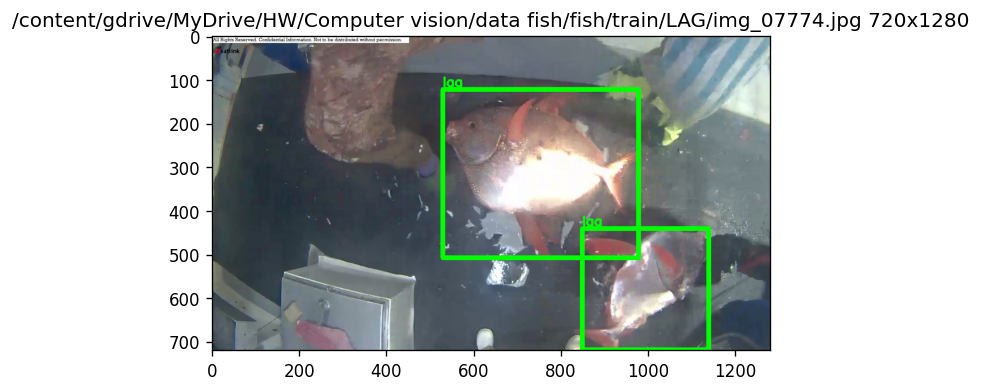

In [8]:
annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Распределение размеров разметки

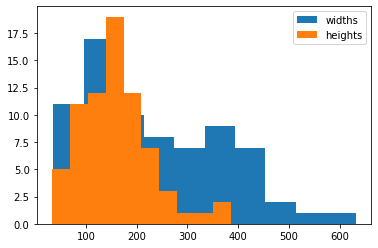

In [9]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights)
plt.legend(['widths','heights']);

## Экстрактор признаков

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50 #2, EfficientNetB3
from tensorflow.keras.applications.vgg16 import VGG16

IMG_HEIGHT = 736
IMG_WIDTH =  1184

features = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False
    
feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58900480/58889256 [==============================] - 0s 0us/step
(None, 23, 37, 512)


### Сетка якорей (anchor grid)

In [11]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])
print(FEATURE_SHAPE)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150. 

# сетка якорей, размер определяется соотношением 
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

ANCHOR_CENTERS.shape

(23, 37)


(2, 23, 37)

In [12]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']
                
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))
        
        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]
            
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

#keras.activations.softmax(x, axis=-1)

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            
            label = np.empty(6)
            
            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles
    
    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)
    
    return [rectangles[i] for i in indices]

## Валидация энкодинга/декодинга якорей

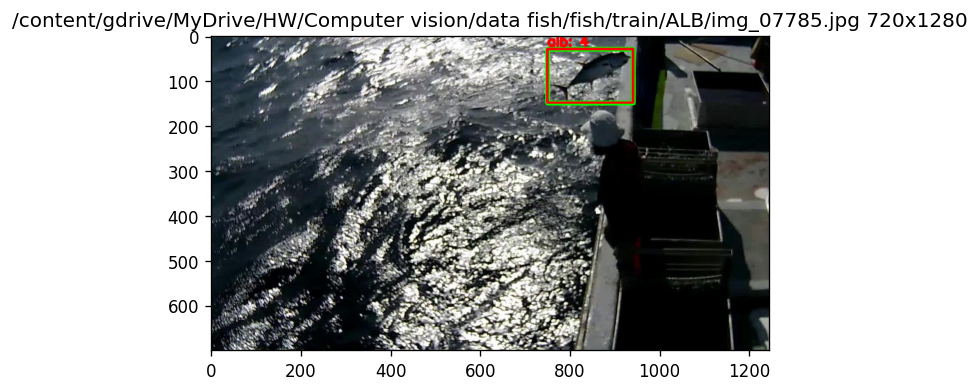

In [13]:
annotation = boxes['alb'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Валидация энкодинга/декодинга якорей

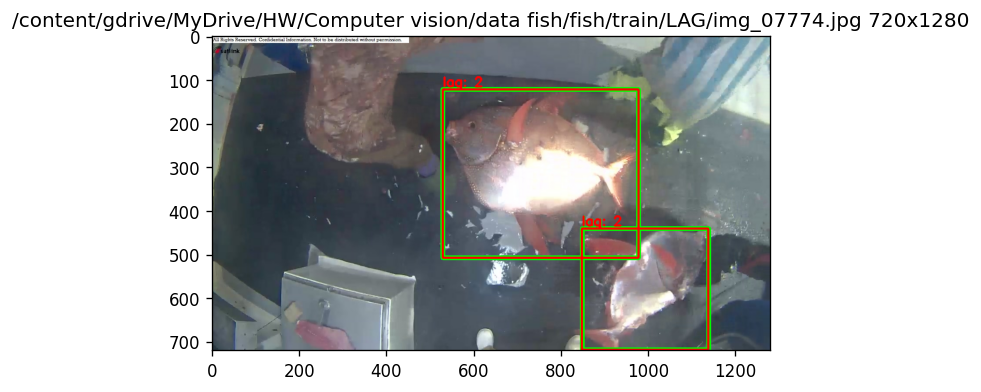

In [14]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [15]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6], 
                                      y_pred[..., 6],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):
    
    """Focal Loss"""
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy
    
    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_tr, y_pr):
    
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]
    
    cross_entropy = K.categorical_crossentropy(y_true[..., :6], 
                                               y_pred[..., :6],
                                               from_logits=True)
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         labels=y_true, logits=y_pred
#         )
    return cross_entropy

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))
    
    # TODO: добавьте функцию потерь для классификации детекции
    cls_loss = classification_loss(y_true, y_pred)
    #cls_loss = class_loss(y_true, y_pred)


    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)

    
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss + cls_loss

## Загрузка данных

In [16]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, tf.keras.applications.resnet_v2.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                #print('boxes[j]', boxes[j])
                y_ = encode_anchors(boxes[j], img_shape)
                y.append(y_)
                X.append(img)
            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [17]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1), 
                                activation='linear',
                                kernel_regularizer='l2')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)

## Обучение

In [18]:
adam = tf.keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics=[confidence_loss])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen, 
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          callbacks=[checkpoint])

Epoch 1/100
 9/10 [========================>.....] - ETA: 2s - loss: 5.0405 - confidence_loss: 0.8684
Epoch 1: loss improved from inf to 4.87374, saving model to fishdetector.hdf5
10/10 [==============================] - 36s 2s/step - loss: 4.7031 - confidence_loss: 0.8562
Epoch 2/100
 8/10 [======================>.......] - ETA: 1s - loss: 3.7465 - confidence_loss: 0.7329
Epoch 2: loss improved from 4.87374 to 3.59192, saving model to fishdetector.hdf5
10/10 [==============================] - 7s 662ms/step - loss: 3.2897 - confidence_loss: 0.7142
Epoch 3/100
 7/10 [===================>..........] - ETA: 1s - loss: 1.7981 - confidence_loss: 0.6425
Epoch 3: loss improved from 3.59192 to 1.82950, saving model to fishdetector.hdf5
10/10 [==============================] - 7s 652ms/step - loss: 1.7064 - confidence_loss: 0.6371
Epoch 4/100
 6/10 [================>.............] - ETA: 2s - loss: 1.3897 - confidence_loss: 0.5965
Epoch 4: loss improved from 1.82950 to 1.36830, saving model to 

## Результат работы детектора

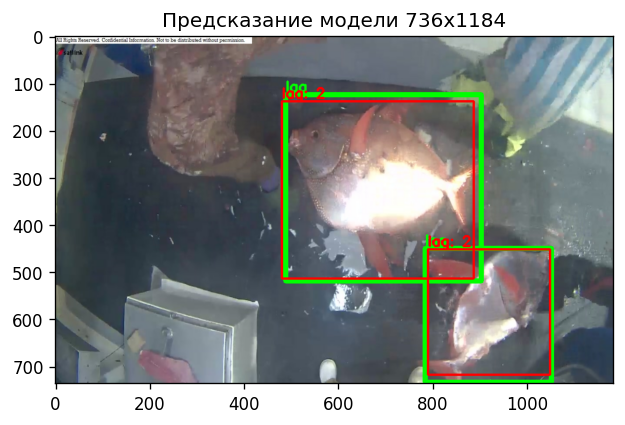

In [20]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

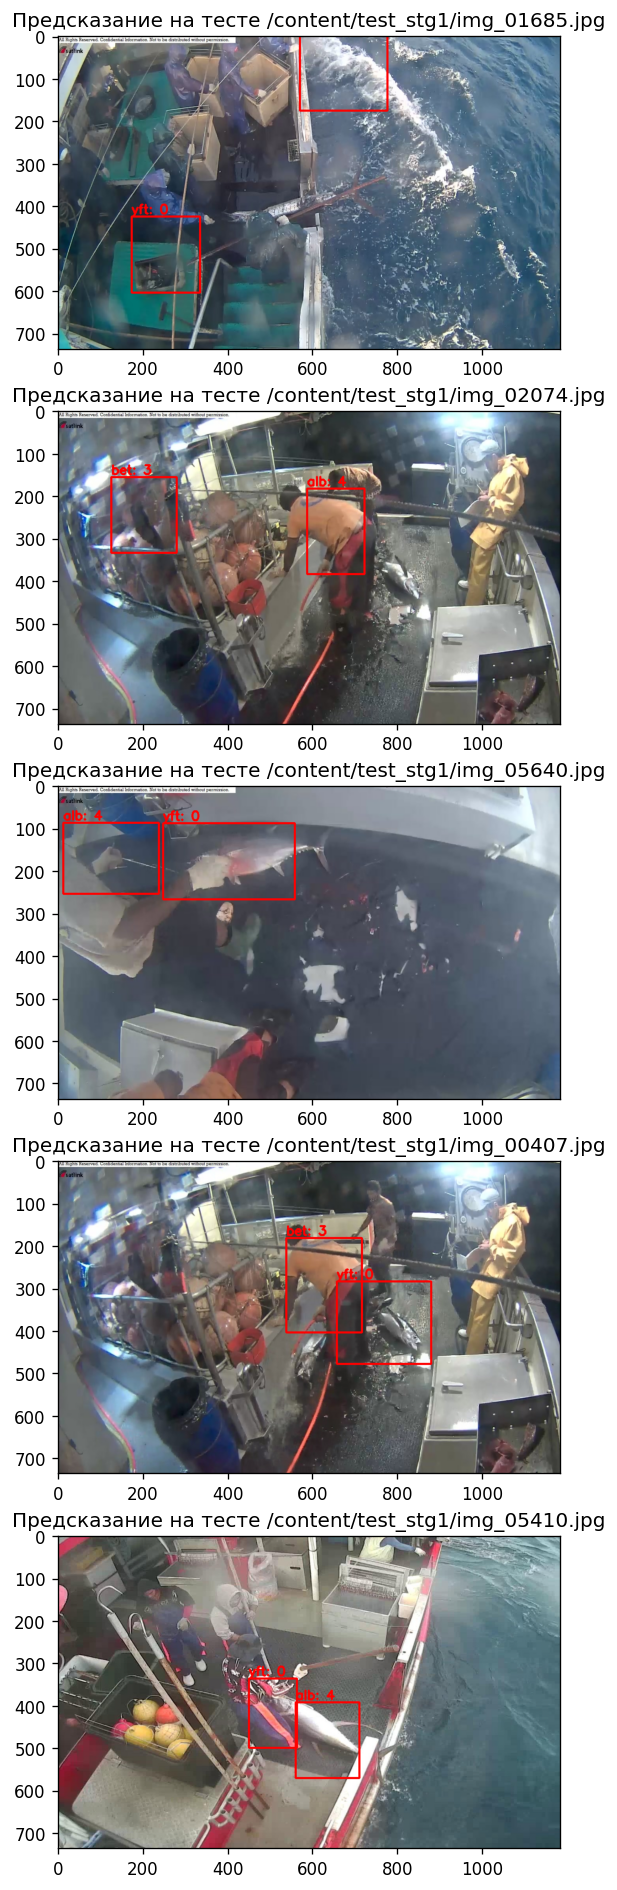

In [21]:
test_images = glob('/content/test_stg1/*.jpg')[:5]

plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)
    
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

In [22]:
fish_classes

array(['yft', 'shark', 'lag', 'bet', 'alb', 'dol'], dtype=object)

In [23]:
def make_predictions():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])
    
    for i, file in enumerate(glob('/content/test_stg1/*.jpg')):
        bn = os.path.basename(file)
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[5]
        ptable.loc[i, 'BET'] = decoded[1]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[3]
        ptable.loc[i, 'SHARK'] = decoded[0]
        ptable.loc[i, 'YFT'] = decoded[2]
        
        ptable.loc[i, 'NoF'] = 0.123081
        ptable.loc[i, 'OTHER'] = 0.079142

    i += 1    
    
    for j, file in enumerate(glob('/content/test_stg2/*.jpg')):
        bn = os.path.basename(file)
        
        bn = "test_stg2/" + bn
        _, sample_img = load_img(file)
        
        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        
        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[5]
        ptable.loc[i + j, 'BET'] = decoded[1]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[3]
        ptable.loc[i + j, 'SHARK'] = decoded[0]
        ptable.loc[i + j, 'YFT'] = decoded[2]
        
        ptable.loc[i + j, 'NoF'] = 0.123081
        ptable.loc[i + j, 'OTHER'] = 0.079142

    return ptable   

In [24]:
pred_table = make_predictions()
pred_table.to_csv("neto_submit.csv", index=False)
print(os.listdir("./"))

['.config', 'neto_submit.csv', 'fishdetector.hdf5', 'test_stg1', 'train', 'test_stg2', 'gdrive', '__MACOSX', 'sample_data']


In [25]:
pred_table

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_01685.jpg,0.08619,0.279075,0.187396,0.32618,0.123081,0.079142,0.05235,0.068809
1,img_02074.jpg,0.130981,0.068734,0.197328,0.334983,0.123081,0.079142,0.174604,0.09337
2,img_05640.jpg,0.062776,0.178365,0.094115,0.272503,0.123081,0.079142,0.309278,0.082963
3,img_00407.jpg,0.15675,0.069952,0.152148,0.297389,0.123081,0.079142,0.163514,0.160247
4,img_05410.jpg,0.082356,0.11623,0.151131,0.098364,0.123081,0.079142,0.508388,0.043531
...,...,...,...,...,...,...,...,...,...
13148,test_stg2/image_08049.jpg,0.075369,0.290597,0.084656,0.221645,0.123081,0.079142,0.218735,0.108999
13149,test_stg2/image_05846.jpg,0.078618,0.080691,0.115725,0.154676,0.123081,0.079142,0.493575,0.076714
13150,test_stg2/image_02809.jpg,0.03487,0.056368,0.777911,0.020055,0.123081,0.079142,0.081471,0.029325
13151,test_stg2/image_06706.jpg,0.07057,0.065704,0.347004,0.354974,0.123081,0.079142,0.091733,0.070015
